In [39]:
from __future__ import division
from fenics import *
from mpi4py import MPI
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import warnings
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [40]:
parameters["form_compiler"]["representation"] = "quadrature"

# (To shut off deprecation warnings)
import warnings
from ffc.quadrature.deprecation \
    import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("ignore", QuadratureRepresentationDeprecationWarning)

In [41]:
# suppress FEniCS output to terminal
set_log_active(False)


# output directory
output_dir = ""


comm = MPI.COMM_WORLD  # MPI communications
rank = comm.Get_rank()  # number of current process
size = comm.Get_size()  # total number of processes

In [42]:

# mesh = Mesh()
# # with XDMFFile(comm, "mesh.xdmf") as infile:
# #     infile.read(mesh)
# with XDMFFile(comm, "mesh/glacier2.xdmf") as infile:
#     infile.read(mesh)


In [43]:
# # Output the minimum element size
# min_element_size = mesh.hmin()
# print("Minimum element size: {:.4f}".format(min_element_size))

In [44]:
mesh = Mesh("mesh/notch.xml")

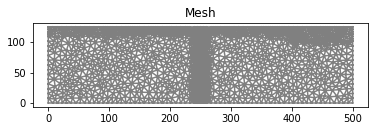

In [45]:
# Plot the mesh
plot(mesh,title='Mesh')
plt.show()

In [46]:
nd = mesh.geometry().dim()  # mesh dimensions (2D or 3D)


In [47]:
mesh.num_vertices()


1909

In [48]:
# Calculate minimum mesh size
min_mesh_size = mesh.hmin()
# Print the minimum mesh size
print("Minimum mesh size:", min_mesh_size)

Minimum mesh size: 2.9474919917003257


In [49]:
"""Material parameters."""

rho_ice = 917  # density of ice (kg/m^3)
rho_H2O = 1020  # density of seawater (kg/m^3)
grav = 9.81  # gravity acceleration (m/s**2)
temp = -10 + 273  # temperature (K)
B0 = 2.207e-3  # viscosity coefficient (kPa * yr**(1/3))
B0 *= 1e3  # convert to (Pa * yr**(1/3))
B0 *= (365*24)**(1/3)  # convert to (Pa * hour**(1/3))
BT = B0*np.exp(3155/temp - 0.16612/(273.39 - temp)**1.17)


In [50]:
"""Damage parameters."""

alpha = 0.21  # weight of max principal stress  in Hayhurst criterion
beta = 0.63  # weight of von Mises stress in Hayhurst criterion
r = 0.43  # damage exponent
B = 5.232e-7  # damage coefficient
k1, k2 = -2.63, 7.24  # damage rate dependency parameters
Dcr = 0.6  # critical damage
Dmax = 0.99  # maximum damage
lc = 10  # nonlocal length scale
# prec_ratio = 0.08
hs_ratio = 0 # water level in crevasse (normalized with crevasse height)
hw_ratio = 0 # water level at right terminus (normalized with glacier thickness)
prec_ratio = 0.08 # depth of pre-crack (

In [51]:
"""Set simulation time and timestepping options."""

t_total = 480  # total time (hours)
t_elapsed = 0  # current elapsed time (hours)
t_delay_dmg = 0  # delay damage (hours)
max_Delta_t = 0.5  # max time increment (hours)
max_Delta_D = 0.1  # max damage increment
output_increment = 10  # number of steps between output
time_counter = 0  # current time step

In [52]:

"""Mesh deta1ils."""
L, H = 500, 125  # domain dimensions
hs = 0  # water level in crevasse (normalized with crevasse height)
hw = hw_ratio*H  # water level at terminus (absolute height)
# mesh = load_mesh(output_dir + "mesh/hdf5/notch.h5")
# nd = mesh.geometry().dim()  # mesh dimensions (2D or 3D)

In [53]:

"""Define function spaces."""
S1 = FunctionSpace(mesh, "CG", 1)  # first order scalar space
S2 = FunctionSpace(mesh, "CG", 2)  # second order scalar space
V1 = VectorFunctionSpace(mesh, "CG", 1)  # first order vector space
V2 = VectorFunctionSpace(mesh, "CG", 2)  # second order vector space
P1 = FiniteElement("CG", mesh.ufl_cell(), 1)  # first order scalar element
P2 = VectorElement("CG", mesh.ufl_cell(), 2)  # second order vector element
V = FunctionSpace(mesh, MixedElement([P2, P1]))  # mixed finite element

In [65]:
"""Quadrature elements and function spaces."""

deg_quad = 3
scalar_quad = FiniteElement("Quadrature", cell=mesh.ufl_cell(),
                            degree=deg_quad, quad_scheme="default")
vector_quad = VectorElement("Quadrature", cell=mesh.ufl_cell(),
                            degree=deg_quad, quad_scheme="default")
SQ = FunctionSpace(mesh, scalar_quad)  # quadrature points in scalar space
VQ = FunctionSpace(mesh, vector_quad)  # quadrature points in vector space
form_params = {"quadrature_degree": deg_quad}


"""Coordinates of nodes on initial mesh configuration."""

X1, X2 = S1.tabulate_dof_coordinates().reshape((-1, nd)).T  # coordinates
n_local = len(X1)  # number of coordinates on local process
n_global = S1.dim()  # number of coordinates in global system


"""Coordinates of quadrature points on initial mesh configuration."""

XQ1, XQ2 = SQ.tabulate_dof_coordinates().reshape((-1, nd)).T  # coordinates
nQ_local = len(XQ1)  # number of quadrature points on local process
nQ_global = SQ.dim()  # number of quadrature points in global system



Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [69]:
def mwrite(filename, my_list):
    MPI.barrier(comm)
    if rank == 0:
        with open(filename, "w") as f:
            for item in my_list:
                f.write("%s" % item)


def mprint(*argv):
    if rank == 0:
        out = ""
        for arg in argv:
            out = out + str(arg)
        # this forces program to output when run in parallel
        print(out, flush=True)


In [71]:
mprint("Number of vertices      : {}".format(SQ.dim()))
mprint("Number of cells         : {}".format(VQ.dim()))
# mprint("Number of DoF           : {}".format(V.dim()))
# mprint("Number of processes     : {}".format(size))
# mprint("Number of DoF/process   : {}".format(int(V.dim() / size)))
# mprint("-----------------------------------------------------")

Number of vertices      : 21438
Number of cells         : 42876


Number of vertices      : 10719
Number of cells         : 21438

Number of vertices      : 3573
Number of cells         : 7146

Number of vertices      : 1909
Number of cells         : 3818

Number of vertices      : 7390
Number of cells         : 14780

In [ ]:
class left_edge(SubDomain):
    """Boundary on the left domain edge."""
    def inside(self, x, on_boundary): return near(x[0], 0) and on_boundary


class right_edge(SubDomain):
    """Boundary on the right domain edge."""
    def inside(self, x, on_boundary): return near(x[0], L) and on_boundary


class bottom_edge(SubDomain):
    """Boundary on the bottom domain edge."""
    def inside(self, x, on_boundary): return near(x[1], 0) and on_boundary


class top_edge(SubDomain):
    """Boundary on the top domain edge."""
    def inside(self, x, on_boundary): return near(x[1], H) and on_boundary


""" Define boundaries and boundary conditions. """

left = left_edge()
right = right_edge()
bottom = bottom_edge()
top = top_edge()

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
bottom.mark(boundaries, 3)
top.mark(boundaries, 4)
ds = Measure("ds", subdomain_data=boundaries)

free_slip_left = DirichletBC(V.sub(0).sub(0), Constant(0), left)
free_slip_bottom = DirichletBC(V.sub(0).sub(1), Constant(0), bottom)
BC = [free_slip_left, free_slip_bottom]

In [ ]:
"""define functions that are required to solve the problem"""

def bodyforce(dmg, y, h=0):
    """Gravity loading as a body force. Fully failed points have
        no density unless they are filled with water. Then they
        have the same density as water.
    """
    Dcr = 0.6
    b = Function(VQ)  # body force as vector function
    by = Function(SQ)  # y-component of vector function
    for i in range(nQ_local):
        if dmg.vector()[i] < Dcr:
            by.vector()[i] = -rho_ice*grav
        if (dmg.vector()[i] >= Dcr)*(y[i] <= h):
            by.vector()[i] = -rho_H2O*grav
    assign(b.sub(1), by)
    return b

def hydrostatic(h):
    h_expression = Expression(("(h - x[1] > 0 ?-rho_H2O * grav*(h - x[1]) : 0)",0), h=hw, rho_H2O=rho_H2O, grav=grav, degree=1)
    return h_expression

def pore_pressure(dmg, x, y, h):
	"""Hydraulic pressure from poro-mechanics formulation."""
	Dcr = 0.6
	b_poro = Function(SQ)
	dmg_local = dmg.vector().get_local()
	for i in range(nQ_local):
		if dmg_local[i] >= Dcr:
			b_poro.vector()[i] = rho_H2O*grav*np.fmax(h - y[i], 0)*dmg_local[i]
	return b_poro


def surface_crevasse_level(dmg, y, hsr, pr):
	"""dynamically compute water level in the surface crevasse"""
	crevasse_depth = 0
	crevasse_surface = 0
	if hsr > 0:
		x2_dmg = y[dmg.vector().array() >= 0.99]
		if len(x2_dmg) > 0:
			x2_dmg_local_max = max(max(x2_dmg), H)
			x2_dmg_local_min = max(min(x2_dmg), 0)
		else:
			x2_dmg_local_max = H
			x2_dmg_local_min = H*(1.0-pr)
		x2_dmg_max = comm.allreduce(x2_dmg_local_max, op=MPI.MAX)
		x2_dmg_min = comm.allreduce(x2_dmg_local_min, op=MPI.MIN)
		crevasse_depth = float(x2_dmg_max - x2_dmg_min)
		crevasse_surface = crevasse_depth*hsr + x2_dmg_min
	return crevasse_depth, crevasse_surface

In [ ]:
"""Define constitutive and kinematic relationships."""


def D(u):
    """Symmetric gradient operator."""
    return sym(nabla_grad(u))


def DII(u):
    """Second strain invariant."""
    return (0.5*(D(u)[0, 0]**2 + D(u)[1, 1]**2) + D(u)[0, 1]**2)


def eta1(u, n=3, gam=1e-14):
    """Nonlinear viscosity."""
    return 0.5*BT*(DII(u) + gam)**((1 - n)/2/n)


# """ Define damage functions. """
# def sigma(u):
#     et = eta1(u)
#     et =D(u)
#     return 2*et*et
    

def c_bar(dmg=None):
    """Implicit gradient damage constant term."""
    c = Function(SQ)
    if dmg:
        c.vector()[dmg.vector()[:] < Dcr] = 0.5*(lc**2)
    else:
        c.vector()[:] = 0.5*(lc**2)
    return c


def update_psi(dmg):
    """Function for enforcing incompressibility."""
    psi = Function(S2)
    psi.vector()[:] = 1
    failed_points = dmg.vector()[:] > Dcr  # failed material points
    psi.vector()[failed_points] = 1e-32
    return psi


# def surface_crevasse_level(dmg, y):
#     """dynamically compute water level in the surface crevasse"""
#     cs = 0
#     if hs > 0:
#         x2_dmg = y[dmg.vector().get_local() > Dcr]
#         if len(x2_dmg) > 0:
#             x2_dmg_local_max = min(max(x2_dmg), H)
#             x2_dmg_local_min = max(min(x2_dmg), 0)
#         else:
#             x2_dmg_local_min = H
#             x2_dmg_local_max = 0
#         x2_dmg_max = comm.allreduce(x2_dmg_local_max, op=MPI.MAX)
#         x2_dmg_min = comm.allreduce(x2_dmg_local_min, op=MPI.MIN)
#         cs = float(x2_dmg_max - x2_dmg_min)*hs + x2_dmg_min
#     return cs

def np_array(x):
    """converts x in to a vector format computed at the nodes"""
    return x.vector().get_local()


def mac(x):
    """Macaulay's bracket"""
    return (x+abs(x))/2


In [ ]:
"Define damage function."""

dmg = Function(SQ)
deg = Function(SQ)

# dmg.vector()[(L/2 - 2*lc < XQ1)*(XQ1 < L/2 + 2*lc)*(H*(1-0.08) < XQ2)] = Dmax
# # dmg.vector()[(L/2 - 5 < X1)*(X1 < L/2 + 5)*(H - 10 < X2)] = Dmax

"""define pre-crack zone"""
for i in range(nQ_local):
    if ((L - lc)/2 < XQ1[i])*(XQ1[i] < (L + lc)/2)*(XQ2[i] > H*(1 - 0.08)):
        dmg.vector()[i] = 0.999
#     else:
#         dmg.vector()[i] = 0

In [ ]:
# dmg.vector()[(L/2 - 5 < XQ1)*(XQ1 < L/2 + 5)*(H - 10 < XQ2)] = Dmax

In [ ]:
# dmg.vector().get_local()

In [ ]:
jet = cm.jet
rainbow = cm.rainbow
redblue = cm.coolwarm
viridis = cm.viridis
plasma = cm.plasma
magma = cm.magma

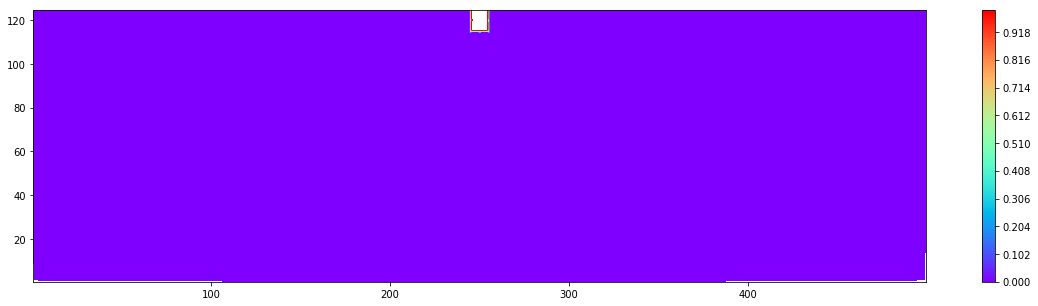

In [ ]:
plt.figure(figsize=(20, 5))
tem = dmg.vector().get_local()
plot12 = plt.tricontourf(XQ1, XQ2, tem, 360, cmap=rainbow)
plt.colorbar(plot12)

In [ ]:
"""Initial guess for Picard iterations."""

uk = Function(V2)  # velocity
pk = Function(S1)  # pressure


comm.Barrier()


In [ ]:
"""define crack tip coordinate"""
cracktip_coor = H*(1-prec_ratio)

In [ ]:
comm.Barrier()


"""Main time loop."""
#t_total t_elapsed
while t_elapsed < t_total:

    time_counter += 1
    # get current configuration coordinates
    x1, x2 = S1.tabulate_dof_coordinates().reshape((-1, nd)).T
    xQ1, xQ2 = SQ.tabulate_dof_coordinates().reshape((-1, nd)).T
    n_local = len(x1)  # number of coordinates on local process
    n_global = S1.dim()  # number of coordinates in global system
    nQ_local = len(xQ1)  # number of quadrature points on local process
    nQ_global = SQ.dim()  # number of quadrature points in global system

    u, p = TrialFunctions(V)  # trial functions in (V2, S1) space
    v, q = TestFunctions(V)  # test functions in (V2, S1) space

    # hydraulic pressure in surface crevasse
    cdepth, csurfx2 = surface_crevasse_level(dmg=dmg, y=XQ2, hsr=hs_ratio, pr=prec_ratio)  # height of water column
    b_poro = pore_pressure(dmg=dmg, x=XQ1, y=XQ2, h=csurfx2)  # hydraulic pressure
    # pHD = pore_pressure(dmg=dmg, y=xQ2, h=cs)  # hydraulic pressure


    # define loading terms
    b_grav = bodyforce(dmg=dmg, y=XQ2, h=csurfx2) # gravity for ice and water
    b_hw = hydrostatic(h=hw)  # terminus pressure

    # normal function to mesh
    nhat = FacetNormal(mesh)

  # incompressibility terms

    penalty = False

    psi = update_psi(dmg)
     ### update degradation function with damage value from previous step
    deg.vector()[:]= np.fmax(1-np_array(dmg),1e-6)

    # define variational form
    LHS = (inner(D(v), 2*deg*eta1(uk)*D(u)) - deg*div(v)*p
           + psi*q*div(u))*dx
    if penalty:
        LHS += 1e12*inner(nabla_div(u), psi*div(v))*dx  # penalty term
    # RHS = (1-dmg)*inner(v, b_grav)*dx  # ice and water gravity
    RHS = inner(v, b_grav)*dx  # ice and water gravity
    if hs > 0:
        RHS += inner(nabla_div(v), b_poro)*dx  # hydraulic pressure in damage zone
    if hw > 0:
        RHS += inner(v, b_hw)*ds(2)  # terminus pressure

    """ Picard iterations. """

    eps_local = 1  # local error norm
    eps_global = 1  # global error norm
    tol = 1e-4  # error tolerance
    picard_count = 0  # iteration count
    picard_max = 50  # maximum iterations
    w = Function(V)  # empty function to dump solution

    while (abs(eps_global) > tol) and (picard_count < picard_max):

        # solve the variational form
        solve(LHS == RHS, w, BC, form_compiler_parameters=form_params)
        u, p = w.split(deepcopy=True)
        u1, u2 = u.split(deepcopy=True)

        # compute error norms
        u1k, u2k = uk.split(deepcopy=True)
        diff1 = u1.vector().get_local() - u1k.vector().get_local()
        diff2 = u2.vector().get_local() - u2k.vector().get_local()
        diffp = p.vector().get_local() - pk.vector().get_local()
        eps1 = np.linalg.norm(diff1)/np.linalg.norm(u1.vector().get_local())
        eps2 = np.linalg.norm(diff2)/np.linalg.norm(u2.vector().get_local())
        epsp = np.linalg.norm(diffp)/np.linalg.norm(p.vector().get_local())
        # eps1 = np.linalg.norm(diff1)
        # eps2 = np.linalg.norm(diff2)
        # epsp = np.linalg.norm(diffp)

        # update solution for next iteration
        assign(uk, u)
        assign(pk, p)

        comm.Barrier()

        # obtain the max error on the local process
        eps_local = max(eps1, eps2, epsp)
        # obtain the max error on all processes
        eps_global = comm.allreduce(eps_local, op=MPI.MAX)

        # update iteration count
        picard_count += 1
#     print(" Steps, eps1, eps2, eps3, epslocal: %d, %9f, %9f, %9f",picard_count, eps1, eps2, epsp, eps_local )
#     """ Generate numpy arrays from output. """

    # build effective deviatoric stress tensor
    tau = 2*eta1(u)*D(u)
    t11 = project(tau[0, 0], SQ,form_compiler_parameters=form_params).vector().get_local()
    t22 = project(tau[1, 1], SQ,form_compiler_parameters=form_params).vector().get_local()
    t33 = np.zeros(nQ_local)
    t12 = project(tau[0, 1], SQ,form_compiler_parameters=form_params).vector().get_local()

    dmg0 = dmg.vector().get_local()# damage from previous time step
    prs = interpolate(p, SQ).vector().get_local()# effective pressure

    t23 = np.zeros(nQ_local)

    t13 = np.zeros(nQ_local)


    # effective Cauchy stress
    s11, s22, s33, s12, s23, s13 = t11 - prs, t22 - prs, t33 - prs, t12, t23, t13
    
    I1 = s11 + s22 + s33  # effective I1 invariant
    I1_true = (1 - dmg0)*I1 - 3*b_poro.vector().get_local()  # true I1 invariant
    J2 = 0.5*(t11**2 + t22**2 + t33**2) + t12**2  # effective J2 invariant
    vms = np.sqrt(3*J2)  # effective von Mises stress

    lam1 = s33
    lam2 = 0.5*(s11 + s22 + np.sqrt(s11**2 - 2*s11*s22 + 4*(s12**2) + s22**2))
    mps = np.fmax(lam1, lam2)  # effective max principal stress

    # effective Hayhurst stress
    chi = alpha*mps + beta*vms + (1 - alpha - beta)*I1

    
    
    """ Compute the local damage rate and increment. """

    # local damage rate
    dDloc_dt = np.zeros(nQ_local)
    for i in range(nQ_local):
        if (I1[i] > 0 and chi[i] > 0 and dmg0[i] < Dcr):
            k = min(k1 + k2*abs(I1_true[i]/1e6), 30)
            dDloc_dt[i] = B*((chi[i]/1e6)**r)/((1 - dmg0[i])**k)

    # select time increment on each local process
    if max(dDloc_dt) > 0:
        Delta_t_local = float(max_Delta_D/max(dDloc_dt))
        Delta_t_local = min(max_Delta_t*3600, Delta_t_local)
    else:
        Delta_t_local = max_Delta_t*3600

    # obtain the minimum time increment from all processes
    comm.Barrier()
    Delta_t = comm.allreduce(Delta_t_local, op=MPI.MIN)

    # compute the damage increment
    Delta_Dloc = Function(SQ)
    Delta_Dloc.vector()[:] = dDloc_dt*Delta_t

    """ Compute the nonlocal damage increment using implicit gradient. """

    # trial and test functions
    Delta_D = TrialFunction(S1)
    z = TestFunction(S1)

    # define variational form
    LHS = (inner(z, Delta_D)
           + c_bar(dmg)*inner(nabla_grad(z), nabla_grad(Delta_D)))*dx
    RHS = inner(z, Delta_Dloc)*dx

    # solve for the nonlocal damage increment
    w = Function(S1)  # empty function to dump solution
    solve(LHS == RHS, w, form_compiler_parameters=form_params)

    # interpolate nonlocal damage increment at quadrature points
    wq = np.clip(interpolate(w, SQ).vector().get_local(), 0, max_Delta_D)

    # update damage and psi UFL functions
    dmg = Function(SQ)
    if t_elapsed >= t_delay_dmg:
        dmgv = np.clip(dmg0+wq, 0, Dmax)  # 0 < damage < Dmax
        dmgv[dmgv > Dcr] = Dmax
        dmg.vector()[:] = dmgv

    """ Output data to mesh file. """

    Delta_t /= 3600  # convert time increment to hours
    
    
    """ Updated Lagrangian implementation. """

    # split velocity into components in S1 space
    u1, u2 = u.split(deepcopy=True)
    u1 = interpolate(u1, S1).vector().get_local()
    u2 = interpolate(u2, S1).vector().get_local()

    # compute the displacement increment vector Delta_u
    Delta_u1 = Function(S1)
    Delta_u2 = Function(S1)
#     ind1 = x1 > 0  # indices of coordinates where x1 > 0
#     ind2 = x2 > 0  # indices of coordinates where x2 > 0
#     Delta_u1.vector()[ind1] = u1[ind1]*Delta_t
#     Delta_u2.vector()[ind2] = u2[ind2]*Delta_t
    """define pre-crack zone"""
    for i in range(n_local):
        if x1[i] > 0:
            Delta_u1.vector()[i] = u1[i]*Delta_t
        elif x2[i] >0:
            Delta_u2.vector()[i] = u2[i]*Delta_t
    Delta_u = Function(V1)
    assign(Delta_u.sub(0), Delta_u1)
    assign(Delta_u.sub(1), Delta_u2)

    # move the mesh, update coordinates
    ALE.move(mesh, Delta_u)

    # update elapsed time
    t_elapsed += Delta_t


    dmgc = dmg.vector().get_local()
    for i in range(nQ_local):
        # if dmgc[i] >= 0.99:
        if dmgc[i] >= 0.99:
            if XQ2[i] < cracktip_coor:
                cracktip_coor = XQ2[i]
    print("Step %d, Crack depth: %g, time: %0.2f" % (t_elapsed,1-cracktip_coor/H,t_elapsed ))




Step 0, Crack depth: 0.08, time: 0.50
Step 1, Crack depth: 0.08, time: 1.00
Step 1, Crack depth: 0.08, time: 1.50
Step 2, Crack depth: 0.08, time: 2.00
Step 2, Crack depth: 0.08, time: 2.50
Step 3, Crack depth: 0.08, time: 3.00
Step 3, Crack depth: 0.08, time: 3.50
Step 4, Crack depth: 0.08, time: 4.00
Step 4, Crack depth: 0.08, time: 4.50
Step 5, Crack depth: 0.08, time: 5.00
Step 5, Crack depth: 0.08, time: 5.50
Step 6, Crack depth: 0.08, time: 6.00
Step 6, Crack depth: 0.08, time: 6.50
Step 7, Crack depth: 0.08, time: 7.00
Step 7, Crack depth: 0.08, time: 7.50
Step 8, Crack depth: 0.08, time: 8.00
Step 8, Crack depth: 0.08, time: 8.50
Step 9, Crack depth: 0.08, time: 9.00
Step 9, Crack depth: 0.08, time: 9.50
Step 10, Crack depth: 0.08, time: 10.00
Step 10, Crack depth: 0.08, time: 10.50
Step 11, Crack depth: 0.08, time: 11.00
Step 11, Crack depth: 0.08, time: 11.50
Step 12, Crack depth: 0.08, time: 12.00
Step 12, Crack depth: 0.08, time: 12.50
Step 13, Crack depth: 0.08, time: 13.0

In [ ]:
project(u, V, form_compiler_parameters={"quadrature_degree": 3})

In [ ]:
t11 = project(tau[0, 0], SQ,form_compiler_parameters={"quadrature_degree": 2})

In [ ]:
plt.figure(figsize=(20, 5))
# tem = dmg.vector().array()
plot = plt.tricontourf(XQ1, XQ2, s11, 360, cmap=rainbow)
plt.colorbar(plot)
# plt.savefig('s11_hw_00.jpg', dpi=300)

In [ ]:
plt.figure(figsize=(20, 5))
# tem = dmg.vector().array()
plot = plt.tricontourf(XQ1, XQ2, dmgc, 360, cmap=rainbow)
plt.colorbar(plot)
# plt.savefig('s11_hw_00.jpg', dpi=300)